In [18]:
import re
from datetime import date

import numpy as np
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt
import cartopy.crs as ccrs
import cartopy
from matplotlib.patches import Polygon
import pytrap
import geoip2.database
from pyasn import pyasn



In [2]:
df = pytrap.read_nemea("f:linuxdays2023.trapcap")

In [3]:
def plot_snis_stats(df, field):
    df = df[df[field] != ""]
    print(f'Total flows: {len(df)}')
    print(f'Unique SNIs: {len(df[field].unique())}')

    data = df[field].value_counts(normalize=True)[:11]

    _, ax = plt.subplots(figsize=(10, 8))

    ax = sns.barplot(y=data.index, x=data.values*100)

    ax.axes.set_title("Most common " + field, pad=20)
    ax.set_xlabel("Percentage", labelpad=10)
    ax.set_ylabel(field, labelpad=10)
    ax.tick_params(left=False, bottom=False)

    plt.show()


In [4]:
df.head()


,DST_IP,SRC_IP,BYTES,BYTES_REV,LINK_BIT_FIELD,TIME_FIRST,TIME_LAST,DST_MAC,SRC_MAC,DNS_RR_TTL,...,PROTOCOL,TCP_FLAGS,TCP_FLAGS_REV,DNS_NAME,DNS_RDATA,QUIC_SNI,QUIC_USER_AGENT,TLS_ALPN,TLS_JA3,TLS_SNI
0,8.8.8.8,147.32.77.59,75,0,1,1696769869.680,1696769869.680,d4:ad:71:6f:38:fe,d4:3b:04:6d:31:2f,0,...,17,0,0,ext01.citadel.team,[],,,,[],
1,8.8.8.8,147.32.77.59,75,0,1,1696769869.680,1696769869.680,d4:ad:71:6f:38:fe,d4:3b:04:6d:31:2f,0,...,17,0,0,ext01.citadel.team,[],,,,[],
2,147.32.77.59,8.8.8.8,91,0,1,1696769869.702,1696769869.702,d4:3b:04:6d:31:2f,d4:ad:71:6f:38:fe,60,...,17,0,0,ext01.citadel.team,"[49, 57, 50, 46, 57, 51, 46, 49, 54, 55, 46, 4...",,,,[],
3,147.32.77.59,8.8.8.8,91,0,1,1696769869.703,1696769869.703,d4:3b:04:6d:31:2f,d4:ad:71:6f:38:fe,60,...,17,0,0,ext01.citadel.team,"[49, 57, 50, 46, 57, 51, 46, 49, 54, 55, 46, 4...",,,,[],
4,8.8.8.8,147.32.77.59,72,0,1,1696769875.444,1696769875.444,d4:ad:71:6f:38:fe,d4:3b:04:6d:31:2f,0,...,17,0,0,play.google.com,[],,,,[],


Total flows: 135
Unique SNIs: 32


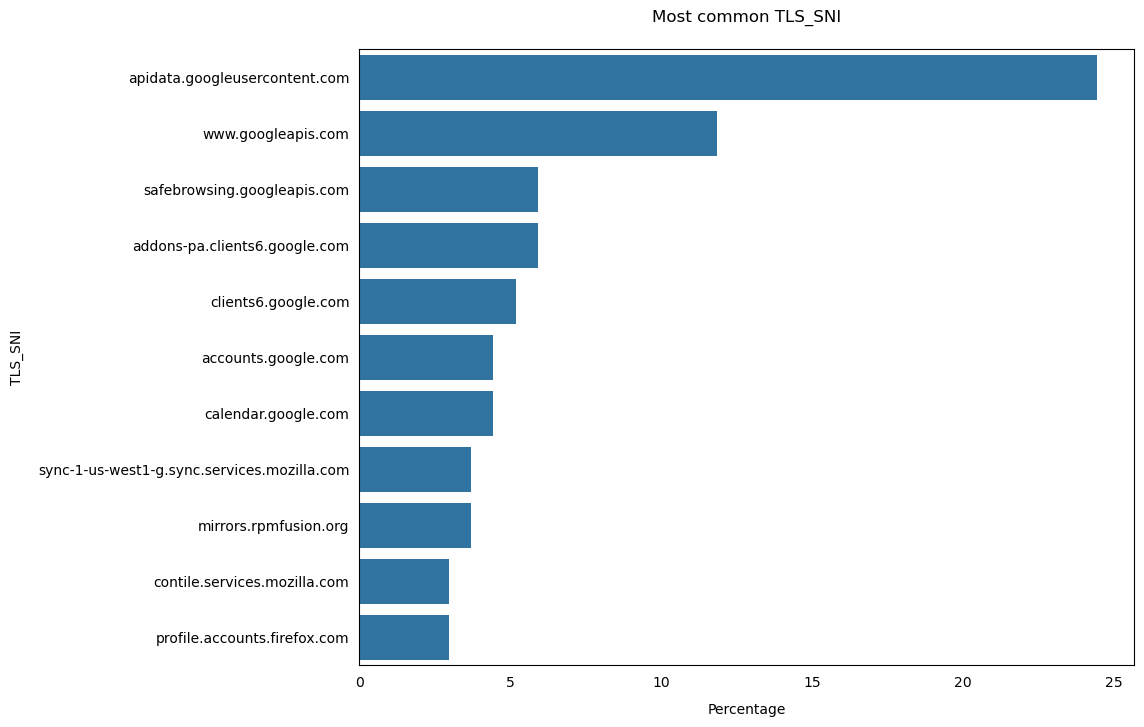

In [5]:
plot_snis_stats(df, "TLS_SNI")

Total flows: 0
Unique SNIs: 0


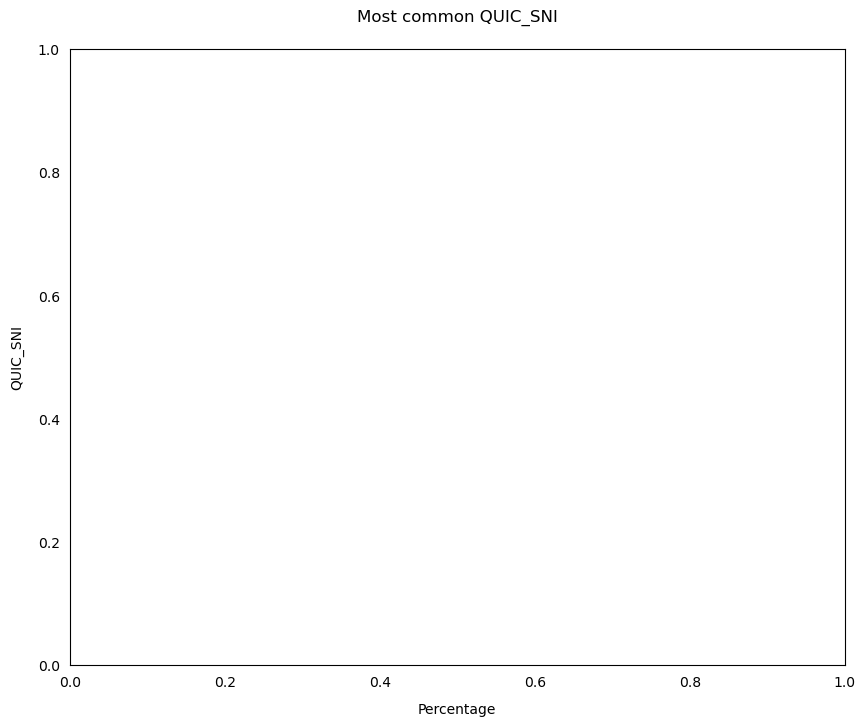

In [6]:
plot_snis_stats(df, "QUIC_SNI")

In [7]:
asndb = pyasn('./rib.20231008.1200.dat')

In [8]:
asns = df.DST_IP.apply(lambda x: asndb.lookup(str(x))[0])
asns = asns.dropna()
asns = asns.astype(int).astype(str)
asns

0       15169
1       15169
2        2852
3        2852
4       15169
        ...  
3228    15169
3229     2852
3230     2852
3231     2852
3232    15169
Name: DST_IP, Length: 3146, dtype: object

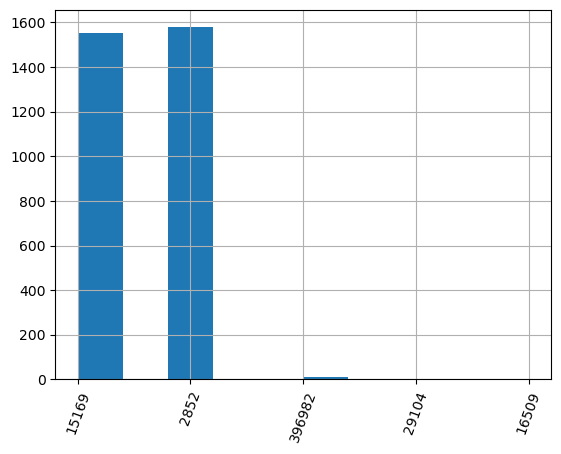

In [9]:
asns.hist()
plt.xticks(rotation=70)
plt.show()

1580


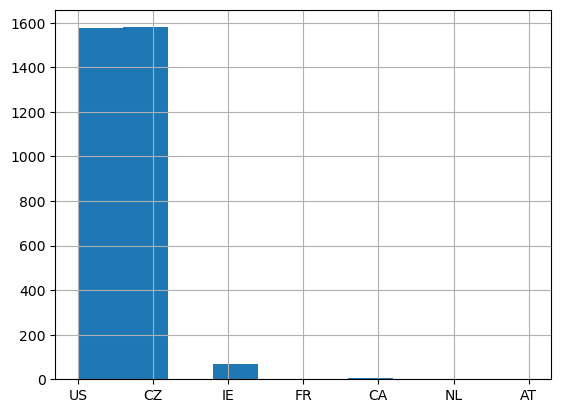

In [52]:
cntry_list = []
coords = {}
coords_cntry = {}
cntry_mass = {}
cntry_maxcount = 1
with geoip2.database.Reader('/usr/share/GeoIP/GeoLite2-City.mmdb') as reader:
    for row in df["DST_IP"]:
        try:
            response = reader.city(str(row))
            cntry_list.append(response.country.iso_code)
            c = (response.location.latitude, response.location.longitude)
            coords_cntry[c] = response.country.iso_code
            if response.country.iso_code not in cntry_mass:
                cntry_mass[response.country.iso_code] = 1
            else:
                cntry_mass[response.country.iso_code] += 1
                if cntry_maxcount < cntry_mass[response.country.iso_code]:
                    cntry_maxcount = cntry_mass[response.country.iso_code]
                
            if c not in coords:
                coords[c] = 1
            else:
                coords[c] += 1
                
        except:
            pass

pd.Series(cntry_list).hist()
print(maxsize)

In [11]:
df

,DST_IP,SRC_IP,BYTES,BYTES_REV,LINK_BIT_FIELD,TIME_FIRST,TIME_LAST,DST_MAC,SRC_MAC,DNS_RR_TTL,...,PROTOCOL,TCP_FLAGS,TCP_FLAGS_REV,DNS_NAME,DNS_RDATA,QUIC_SNI,QUIC_USER_AGENT,TLS_ALPN,TLS_JA3,TLS_SNI
0,8.8.8.8,147.32.77.59,75,0,1,1696769869.680,1696769869.680,d4:ad:71:6f:38:fe,d4:3b:04:6d:31:2f,0,...,17,0,0,ext01.citadel.team,[],,,,[],
1,8.8.8.8,147.32.77.59,75,0,1,1696769869.680,1696769869.680,d4:ad:71:6f:38:fe,d4:3b:04:6d:31:2f,0,...,17,0,0,ext01.citadel.team,[],,,,[],
2,147.32.77.59,8.8.8.8,91,0,1,1696769869.702,1696769869.702,d4:3b:04:6d:31:2f,d4:ad:71:6f:38:fe,60,...,17,0,0,ext01.citadel.team,"[49, 57, 50, 46, 57, 51, 46, 49, 54, 55, 46, 4...",,,,[],
3,147.32.77.59,8.8.8.8,91,0,1,1696769869.703,1696769869.703,d4:3b:04:6d:31:2f,d4:ad:71:6f:38:fe,60,...,17,0,0,ext01.citadel.team,"[49, 57, 50, 46, 57, 51, 46, 49, 54, 55, 46, 4...",,,,[],
4,8.8.8.8,147.32.77.59,72,0,1,1696769875.444,1696769875.444,d4:ad:71:6f:38:fe,d4:3b:04:6d:31:2f,0,...,17,0,0,play.google.com,[],,,,[],
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3229,147.32.77.59,8.8.8.8,104,0,1,1696773191.013,1696773191.013,d4:3b:04:6d:31:2f,d4:ad:71:6f:38:fe,229,...,17,0,0,signaler-pa.clients6.google.com,"[49, 52, 50, 46, 50, 53, 49, 46, 51, 55, 46, 4...",,,,[],
3230,147.32.77.59,8.8.8.8,116,0,1,1696773191.017,1696773191.017,d4:3b:04:6d:31:2f,d4:ad:71:6f:38:fe,229,...,17,0,0,signaler-pa.clients6.google.com,"[50, 97, 48, 48, 58, 49, 52, 53, 48, 58, 52, 4...",,,,[],
3231,147.32.77.59,8.8.8.8,104,0,1,1696773191.019,1696773191.019,d4:3b:04:6d:31:2f,d4:ad:71:6f:38:fe,229,...,17,0,0,signaler-pa.clients6.google.com,"[49, 52, 50, 46, 50, 53, 49, 46, 51, 55, 46, 4...",,,,[],
3232,142.250.185.142,147.32.77.59,3626,8462,1,1696773180.848,1696773181.027,d4:ad:71:6f:38:fe,d4:3b:04:6d:31:2f,0,...,6,26,26,,[],,,,"[2, 170, 70, 121, 223, 40, 79, 36, 6, 149, 218...",clients6.google.com


<Axes: ylabel='PROTOCOL'>

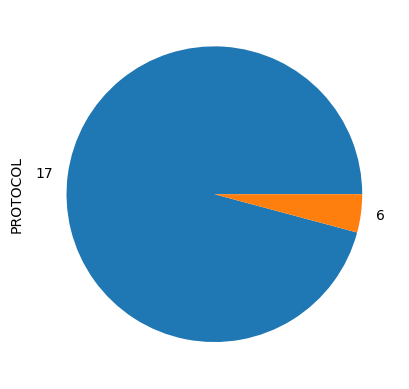

In [12]:
df.PROTOCOL.value_counts().plot.pie()

In [13]:
df[df.DST_PORT==443]

,DST_IP,SRC_IP,BYTES,BYTES_REV,LINK_BIT_FIELD,TIME_FIRST,TIME_LAST,DST_MAC,SRC_MAC,DNS_RR_TTL,...,PROTOCOL,TCP_FLAGS,TCP_FLAGS_REV,DNS_NAME,DNS_RDATA,QUIC_SNI,QUIC_USER_AGENT,TLS_ALPN,TLS_JA3,TLS_SNI
94,34.117.237.239,147.32.77.59,1455,5704,1,1696769896.055,1696769896.291,d4:ad:71:6f:38:fe,d4:3b:04:6d:31:2f,0,...,6,26,26,,[],,,,"[87, 156, 206, 243, 18, 209, 132, 130, 252, 66...",contile.services.mozilla.com
102,2a00:1450:4014:80e::200a,2001:718:2:2905:f26a:d8f2:bd89:cbd6,1815,1445,1,1696769922.002,1696769922.028,d4:ad:71:6f:38:fe,d4:3b:04:6d:31:2f,0,...,6,27,27,,[],,,,"[2, 170, 70, 121, 223, 40, 79, 36, 6, 149, 218...",addons-pa.clients6.google.com
103,142.251.36.110,147.32.77.59,4240,3136,1,1696769922.669,1696769922.791,d4:ad:71:6f:38:fe,d4:3b:04:6d:31:2f,0,...,6,26,26,,[],,,,"[2, 170, 70, 121, 223, 40, 79, 36, 6, 149, 218...",calendar.google.com
153,142.251.36.99,147.32.77.59,5443,12565,1,1696769946.731,1696769975.938,d4:ad:71:6f:38:fe,d4:3b:04:6d:31:2f,0,...,6,26,26,,[],,,,"[87, 156, 206, 243, 18, 209, 132, 130, 252, 66...",ssl.gstatic.com
173,2a00:1450:4014:80f::200e,2001:718:2:2905:f26a:d8f2:bd89:cbd6,1922,1517,1,1696769991.968,1696769992.008,d4:ad:71:6f:38:fe,d4:3b:04:6d:31:2f,0,...,6,27,27,,[],,,,"[2, 170, 70, 121, 223, 40, 79, 36, 6, 149, 218...",drive.google.com
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3046,142.251.36.138,147.32.77.59,2567,28345,1,1696772972.774,1696772972.819,d4:ad:71:6f:38:fe,d4:3b:04:6d:31:2f,0,...,6,27,27,,[],,,,"[2, 170, 70, 121, 223, 40, 79, 36, 6, 149, 218...",safebrowsing.googleapis.com
3104,2a00:1450:4014:80e::2013,2001:718:2:2905:f26a:d8f2:bd89:cbd6,18827,16135,1,1696772812.570,1696773052.871,d4:ad:71:6f:38:fe,d4:3b:04:6d:31:2f,0,...,6,27,31,,[],,,,"[221, 162, 98, 114, 158, 84, 19, 102, 14, 192,...",storage.signal.org
3196,2a00:1450:4014:80f::200a,2001:718:2:2905:f26a:d8f2:bd89:cbd6,4964,4750,1,1696773124.999,1696773131.130,d4:ad:71:6f:38:fe,d4:3b:04:6d:31:2f,0,...,6,26,26,,[],,,http/1.1,"[2, 170, 70, 121, 223, 40, 79, 36, 6, 149, 218...",addons-pa.clients6.google.com
3232,142.250.185.142,147.32.77.59,3626,8462,1,1696773180.848,1696773181.027,d4:ad:71:6f:38:fe,d4:3b:04:6d:31:2f,0,...,6,26,26,,[],,,,"[2, 170, 70, 121, 223, 40, 79, 36, 6, 149, 218...",clients6.google.com


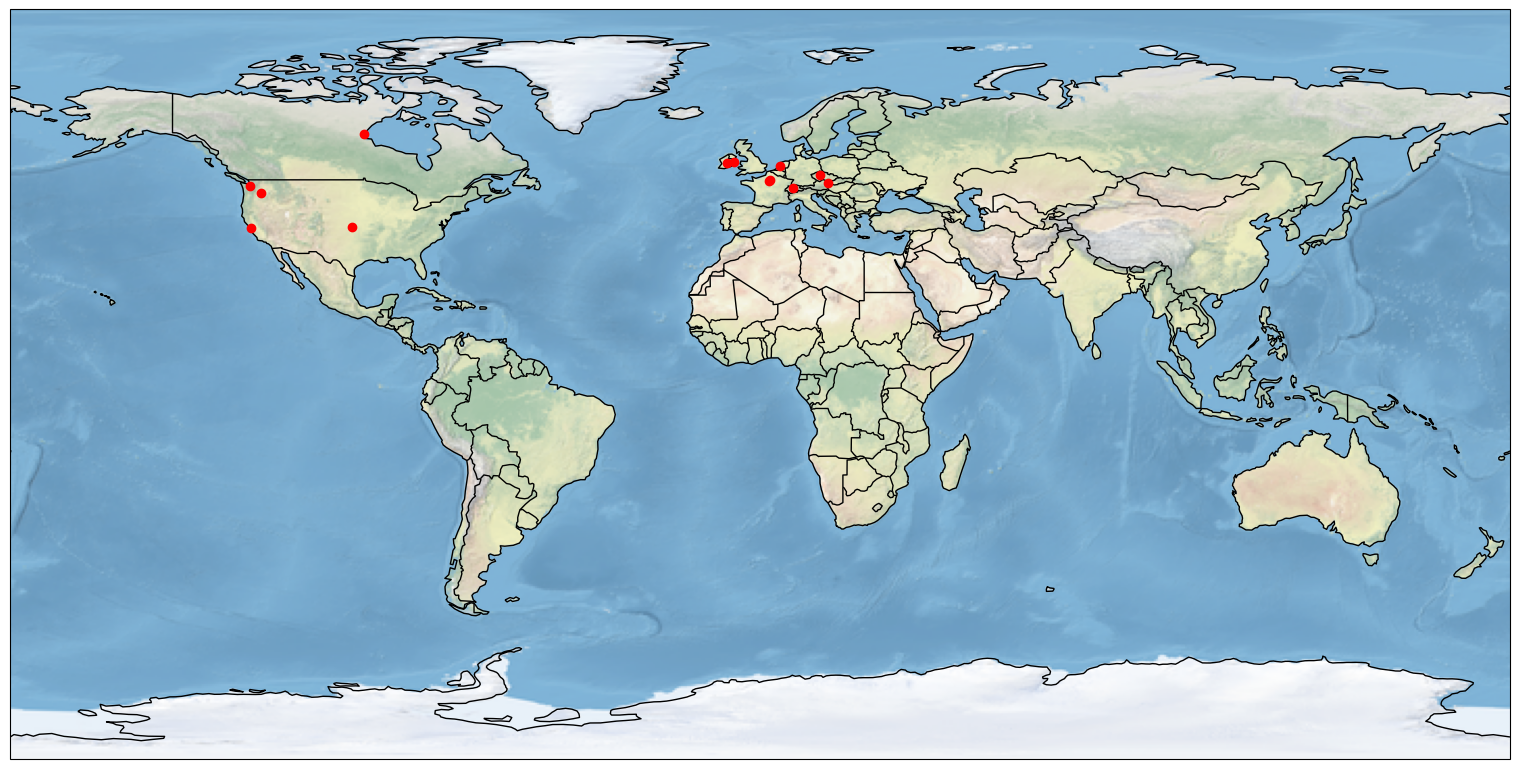

In [45]:
plt.figure(figsize=(15, 15))
ax = plt.axes([0, 0, 1, 1], projection=ccrs.PlateCarree())

ax.coastlines()
ax.add_feature(cartopy.feature.LAND)
ax.add_feature(cartopy.feature.BORDERS)
ax.stock_img()

for k in coords:
    plt.plot(k[1], k[0], color='red', linewidth=10*coords[k]/maxsize, marker='o',
         transform=ccrs.Geodetic(),)

plt.show()

CA Canada 0.31645569620253167
US United States 99.68354430379746
AT Austria 0.06329113924050633
NL Netherlands 0.06329113924050633
IE Ireland 4.2405063291139244
CZ Czech Republic 100.0


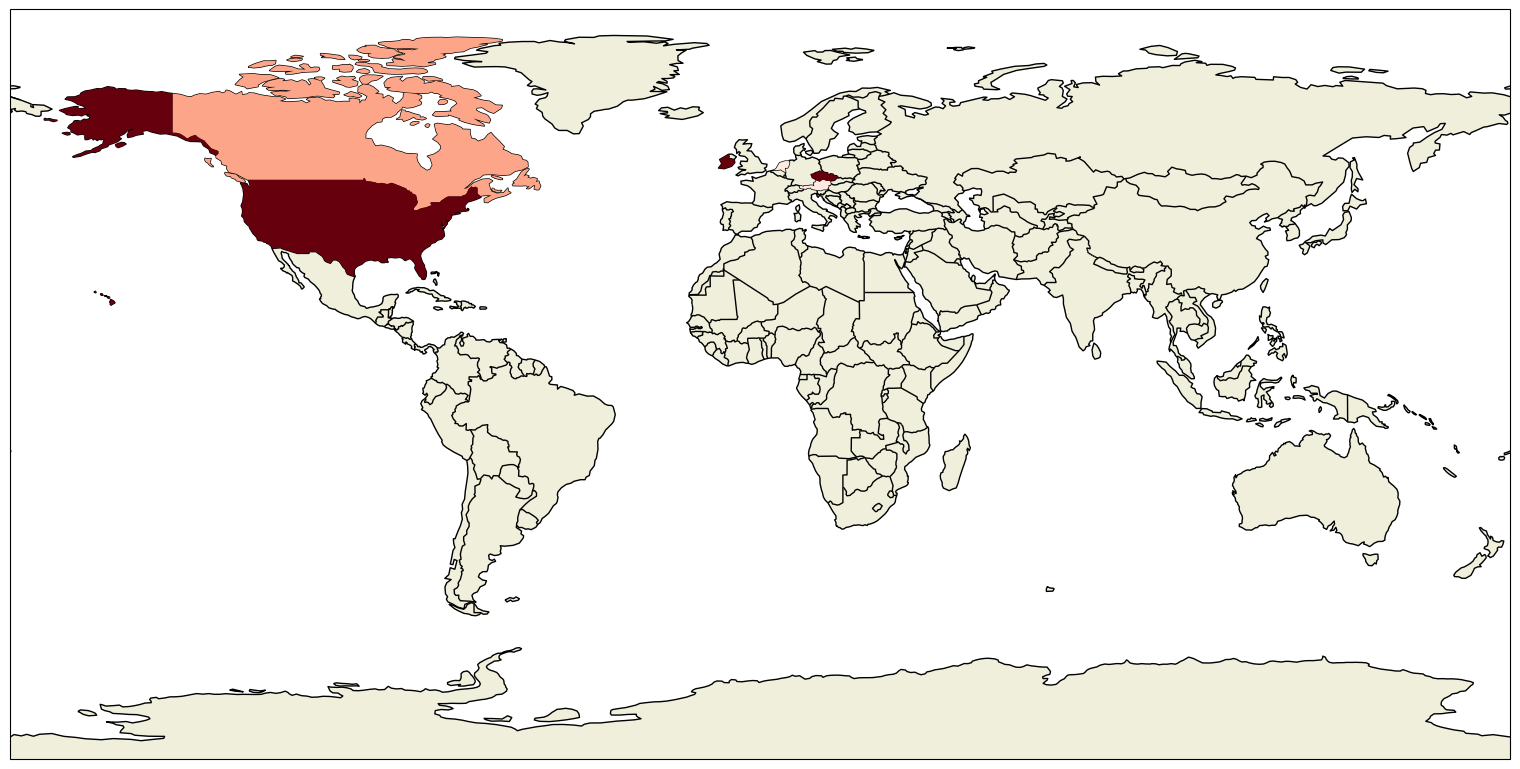

In [66]:
import cartopy.io.shapereader as shpreader
plt.figure(figsize=(15, 15))
ax = plt.axes([0, 0, 1, 1], projection=ccrs.PlateCarree())

ax.coastlines()
ax.add_feature(cartopy.feature.LAND)
ax.add_feature(cartopy.feature.BORDERS)
#ax.stock_img()

shapename = 'admin_0_countries'
countries_shp = shpreader.natural_earth(resolution='110m',
                                        category='cultural', name=shapename)
colors = sns.color_palette("Reds", as_cmap=True)
colors
for country in shpreader.Reader(countries_shp).records():
    isoname = country.attributes["ISO_A2"]
    if isoname in cntry_mass:
        percent = 100 * cntry_mass[isoname] / float(cntry_maxcount)
        print(isoname, country.attributes['NAME_LONG'], percent)
        ax.add_geometries(country.geometry, ccrs.PlateCarree(),
                      facecolor=colors(percent),
                      label=country.attributes['NAME_LONG'])
    

plt.show()